# Sajad Rahmanian 97101683

In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.3 MB/s eta 0:00:00


# Getting to know the BERT model

In [ ]:
from transformers import BertModel, BertTokenizer, BertConfig

config = BertConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert_model = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_text = "قایقی خواهم ساخت، خواهم انداخت به آب. دور خواهم شد از این خاک غریب که در آن هیچ‌کسی نیست که در بیشه عشق قهرمانان را بیدار کند."
tokenizer.tokenize(sample_text)

['قایقی',
 'خواهم',
 'ساخت',
 '،',
 'خواهم',
 'انداخت',
 'به',
 'اب',
 '.',
 'دور',
 'خواهم',
 'شد',
 'از',
 'این',
 'خاک',
 'غریب',
 'که',
 'در',
 'ان',
 'هیچکسی',
 'نیست',
 'که',
 'در',
 'بیشه',
 'عشق',
 'قهرمانان',
 'را',
 'بیدار',
 'کند',
 '.']

# Dataset

In [ ]:
!git clone 'https://github.com/amnghd/Persian_poems_corpus.git'

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


In [ ]:
POETS = ["bahar", "hafez", "kamal", "parvin", "saadi",
         "sanaee", "vahshi", "eraghi", "iqbal", "moulavi"]

In [ ]:
def load_data(poets):
    beyts_all = []
    n_beyts = []
    labels_all = []
    for i, poet in enumerate(poets):
        file_name = poet + "_norm.txt"
        root = "/content/Persian_poems_corpus/normalized"
        path = os.path.join(root, file_name)
        with open(path, 'r') as f:
            txt = f.read().splitlines()[2:]
        m1 = txt[0::2]
        m2 = txt[1::2]
        beyts = [" ".join([x, y]) for x, y in zip(m1, m2)]
        n_beyts.append(len(beyts))
        labels = i * np.ones(len(beyts))
        beyts_all.append(beyts)
        labels_all.append(labels)
    # labels_all = np.concatenate(labels_all)

    return beyts_all, labels_all, np.array(n_beyts)

In [ ]:
X, y, n_beyts = load_data(POETS)
n_beyts_min = n_beyts.min()

In [ ]:
n_beyts_min

5113

In [ ]:
X_final = []
y_final = []
for i, x in enumerate(X):
    idx = np.arange(n_beyts[i])
    np.random.shuffle(idx)
    x_temp = [x[j] for j in range(n_beyts_min)]
    X_final += x_temp
    y_final.append(y[i][:n_beyts_min])
y_final = np.concatenate(y_final)
print(len(y_final), len(X_final))

51130 51130


In [ ]:
class MyDataset(Dataset):
    def __init__(self, beyts, labels, tokenizer_):
        self.beyts = beyts
        self.labels = labels
        self.tokenizer_ = tokenizer_

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        
        beyt = self.beyts[item]
        label = self.labels[item]

        tokenized = self.tokenizer_.encode_plus(
            beyt,
            None,
            add_special_tokens=True,
            max_length= 50,
            padding='max_length',
            return_token_type_ids=True,
            return_tensors='pt'
        )

        tokenized['label'] = torch.LongTensor([int(label)])
        tokenized['input_ids'] = tokenized['input_ids'].flatten()
        tokenized['token_type_ids'] = tokenized['token_type_ids'].flatten()
        tokenized['attention_mask'] = tokenized['attention_mask'].flatten()
        return tokenized

In [ ]:
data = MyDataset(X_final, y_final, tokenizer)
print(f"Length of the data is {len(data)}")

Length of the data is 51130


In [ ]:
train_data, validation_data, test_data = random_split(data, [0.7, 0.1, 0.2])

# Part A)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
# PARAMS
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
class MyModel(nn.Module):
    def __init__(self, 
                 language_model,
                 classifier_model,
                 tuning_method,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer="ADAM",
                 lr=1e-3):
        
        super(MyModel, self).__init__()
        self.criterion = criterion
        self.language_model = language_model
        self.classifier_model = classifier_model
        
        params = self.classifier_model.parameters()
        if tuning_method == "fine-tune":
            params = list(params) + list(self.language_model.parameters())

        if optimizer == "ADAM":
            self.optimizer = torch.optim.Adam(params, lr=lr)
        elif optimizer == "SGD":
            self.optimizer = torch.optim.SGD(params, lr=lr)
        else:
            raise NotImplementedError

    def forward(self, ids, types, mask):
        z = self.language_model(
            input_ids=ids,
            attention_mask=mask,
            token_type_ids=types
        )
        out = self.classifier_model(z["pooler_output"])
        return out

    @staticmethod
    def calculate_accuracy(outputs, true_labels):
        predicted = torch.argmax(outputs, dim=-1)
        accuracy = torch.sum(predicted == true_labels) / true_labels.shape[0]
        return accuracy.item()

    def evaluate(self, evaluation_data, batch_size, phase):
        self.eval()
        evaluation_loader = DataLoader(evaluation_data,
                                       batch_size=batch_size,
                                       shuffle=True)
        loss = 0
        accuracy = 0
        cm = np.zeros((len(POETS), len(POETS)), dtype=int)
        for batch in evaluation_loader:
            with torch.no_grad():
                ids = batch["input_ids"].to(device)
                types = batch["token_type_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels = batch["label"].flatten()
            
                outputs = self.forward(ids, types, mask)
                predicted = torch.argmax(outputs, dim=-1)
                loss += self.criterion(outputs, labels.to(device)).cpu().item() * len(labels)
                accuracy += self.calculate_accuracy(outputs.cpu(), labels) * len(labels)
                if phase == "test":
                    cm += confusion_matrix(labels, 
                                           predicted.cpu(),
                                           labels=[i for i in range(len(POETS))])
        accuracy /= len(evaluation_data)
        loss /= len(evaluation_data)
        return accuracy, loss, cm

    def fit(self, train_data, val_data, batch_size=64, n_epoch=12):

        train_loader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=True)

        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []

        self.train()
        for epoch in range(n_epoch):
            print(f"Epoch #{epoch}:")
            for batch in tqdm(train_loader):
                ids = batch["input_ids"].to(device)
                types = batch["token_type_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels = batch["label"].flatten()

                output = self.forward(ids, types, mask)
                self.optimizer.zero_grad()
                loss = self.criterion(output, labels.to(device))
                loss.backward()
                self.optimizer.step()

            train_acc_epoch, train_loss_epoch, train_cm = self.evaluate(train_data, batch_size, "train")
            val_acc_epoch, val_loss_epoch, val_cm = self.evaluate(val_data, batch_size, "validation")
            self.train_acc.append(train_acc_epoch)
            self.train_loss.append(train_loss_epoch)
            self.val_acc.append(val_acc_epoch)
            self.val_loss.append(val_loss_epoch)

            print(f"training_accuracy={round(train_acc_epoch*100, 2)}%," +\
                  f"train_loss={round(train_loss_epoch, 2)}, " +\
                  f"validation_accuracy={round(val_acc_epoch*100, 2)}%, " +\
                  f"validation_loss={round(val_loss_epoch, 2)}")

In [ ]:
language_model_frozen = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tmp_in = train_data[0]
tmp_out = language_model_frozen(input_ids=tmp_in['input_ids'][None, :],
                                attention_mask=tmp_in['attention_mask'][None, :],
                                token_type_ids=tmp_in['token_type_ids'][None, :])['pooler_output']
linear_in_size = tmp_out.shape[1]

In [ ]:
linear_model = nn.Sequential(*[
    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(linear_in_size, len(POETS))
    ])

In [ ]:
end_to_end_linear_tune_adam = MyModel(language_model_frozen,
                                      linear_model,
                                      "linear_tune",
                                      optimizer="ADAM").to(device)

In [ ]:
end_to_end_linear_tune_adam.fit(train_data,
                                validation_data,
                                batch_size=BATCH_SIZE,
                                n_epoch=EPOCHS)

Epoch #0:


100%|██████████| 1119/1119 [04:28<00:00,  4.17it/s]


training_accuracy=32.12%,train_loss=1.94, validation_accuracy=32.92%, validation_loss=1.94
Epoch #1:


100%|██████████| 1119/1119 [04:33<00:00,  4.10it/s]


training_accuracy=34.71%,train_loss=1.85, validation_accuracy=33.31%, validation_loss=1.87
Epoch #2:


100%|██████████| 1119/1119 [04:32<00:00,  4.10it/s]


training_accuracy=35.57%,train_loss=1.81, validation_accuracy=35.28%, validation_loss=1.83
Epoch #3:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=39.17%,train_loss=1.75, validation_accuracy=37.22%, validation_loss=1.78
Epoch #4:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=37.68%,train_loss=1.76, validation_accuracy=36.96%, validation_loss=1.79
Epoch #5:


100%|██████████| 1119/1119 [04:32<00:00,  4.10it/s]


training_accuracy=41.0%,train_loss=1.7, validation_accuracy=39.59%, validation_loss=1.73
Epoch #6:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=39.31%,train_loss=1.73, validation_accuracy=38.39%, validation_loss=1.76
Epoch #7:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=42.05%,train_loss=1.66, validation_accuracy=40.52%, validation_loss=1.71
Epoch #8:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=40.71%,train_loss=1.7, validation_accuracy=39.39%, validation_loss=1.74
Epoch #9:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=40.71%,train_loss=1.67, validation_accuracy=39.59%, validation_loss=1.71
Epoch #10:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=42.63%,train_loss=1.64, validation_accuracy=41.01%, validation_loss=1.7
Epoch #11:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=41.35%,train_loss=1.68, validation_accuracy=39.76%, validation_loss=1.72
Epoch #12:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=42.89%,train_loss=1.63, validation_accuracy=41.21%, validation_loss=1.68
Epoch #13:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=43.59%,train_loss=1.62, validation_accuracy=41.33%, validation_loss=1.68
Epoch #14:


100%|██████████| 1119/1119 [04:32<00:00,  4.10it/s]


training_accuracy=43.47%,train_loss=1.63, validation_accuracy=41.68%, validation_loss=1.69
Epoch #15:


100%|██████████| 1119/1119 [04:32<00:00,  4.10it/s]


training_accuracy=43.38%,train_loss=1.62, validation_accuracy=42.15%, validation_loss=1.67
Epoch #16:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=43.76%,train_loss=1.61, validation_accuracy=42.17%, validation_loss=1.67
Epoch #17:


100%|██████████| 1119/1119 [04:32<00:00,  4.10it/s]


training_accuracy=44.46%,train_loss=1.6, validation_accuracy=42.81%, validation_loss=1.66
Epoch #18:


100%|██████████| 1119/1119 [04:33<00:00,  4.09it/s]


training_accuracy=43.46%,train_loss=1.63, validation_accuracy=41.6%, validation_loss=1.69
Epoch #19:


100%|██████████| 1119/1119 [04:32<00:00,  4.11it/s]


training_accuracy=43.54%,train_loss=1.62, validation_accuracy=41.83%, validation_loss=1.67


In [ ]:
def f1_from_cm(cm):
    true_pos = np.diag(cm)
    false_pos = np.sum(cm, axis=0) - true_pos
    false_neg = np.sum(cm, axis=1) - true_pos
    precision = np.sum(true_pos) / (np.sum(true_pos) + np.sum(false_pos))
    recall = np.sum(true_pos) / (np.sum(true_pos) + np.sum(false_neg))
    f1 = 2 * recall * precision / (recall + precision)
    return f1

In [ ]:
accuracy, loss, cm = end_to_end_linear_tune_adam.evaluate(test_data, BATCH_SIZE, "test")
f1 = f1_from_cm(cm)
print("Part A Test Results:")
print(f"Accuracy: {100 * accuracy:.2f}%")
print(f"Loss: {loss:.2f}")
print(f"F1: {f1:.2f}")

Part A Test Results:
Accuracy: 41.42%
Loss: 1.68
F1: 0.41


In [ ]:
def plot_conf_mat(cm):
        fig = plt.figure(figsize=(10, 8))
        df_cm = pd.DataFrame(cm, index = [i for i in POETS],
                      columns = [i for i in POETS])
        sns.heatmap(df_cm, annot=True)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        return fig

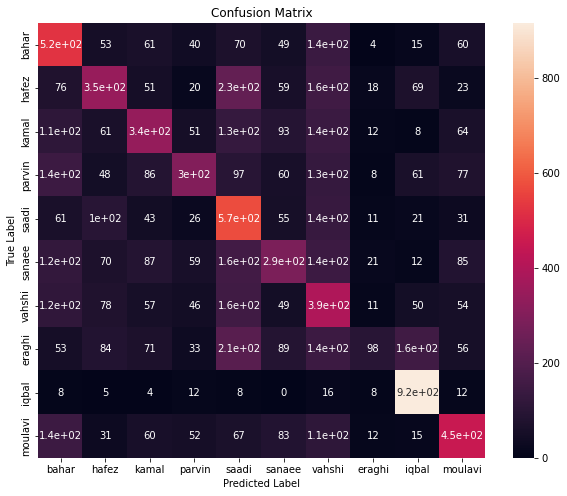

In [ ]:
fig = plot_conf_mat(cm)
plt.show()

# Part B)

In [ ]:
language_model_trainable = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
for param in language_model_trainable.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
linear_model_fine_tune_adam = nn.Sequential(*[
    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(linear_in_size, len(POETS))
    ])

In [ ]:
end_to_end_fine_tune_adam = MyModel(language_model_trainable,
                                    linear_model_fine_tune_adam,
                                    "fine-tune",
                                    optimizer="ADAM",
                                    lr=1e-5).to(device)

In [ ]:
end_to_end_fine_tune_adam.fit(train_data,
                              validation_data,
                              batch_size=BATCH_SIZE,
                              n_epoch=EPOCHS//4)

Epoch #0:


100%|██████████| 1119/1119 [05:21<00:00,  3.49it/s]


training_accuracy=61.82%,train_loss=1.15, validation_accuracy=55.66%, validation_loss=1.3
Epoch #1:


100%|██████████| 1119/1119 [05:17<00:00,  3.52it/s]


training_accuracy=81.29%,train_loss=0.63, validation_accuracy=63.92%, validation_loss=1.06
Epoch #2:


100%|██████████| 1119/1119 [05:19<00:00,  3.51it/s]


training_accuracy=93.87%,train_loss=0.25, validation_accuracy=66.32%, validation_loss=1.06
Epoch #3:


100%|██████████| 1119/1119 [05:18<00:00,  3.52it/s]


training_accuracy=97.74%,train_loss=0.1, validation_accuracy=66.73%, validation_loss=1.25
Epoch #4:


100%|██████████| 1119/1119 [05:17<00:00,  3.52it/s]


training_accuracy=98.07%,train_loss=0.08, validation_accuracy=66.3%, validation_loss=1.44


In [ ]:
accuracy, loss, cm = end_to_end_fine_tune_adam.evaluate(test_data, BATCH_SIZE, "test")
f1 = f1_from_cm(cm)
print("Part B Test Results (ADAM):")
print(f"Accuracy: {100 * accuracy:.2f}%")
print(f"Loss: {loss:.2f}")
print(f"F1: {f1:.2f}")

Part B Test Results (ADAM):
Accuracy: 65.89%
Loss: 1.44
F1: 0.66


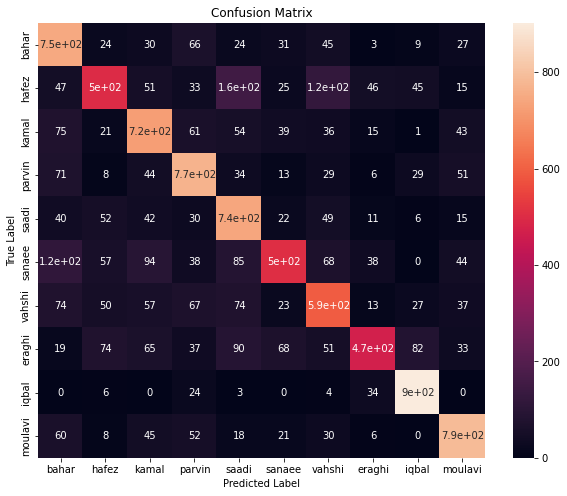

In [ ]:
fig = plot_conf_mat(cm)
plt.show()

In [ ]:
language_model_trainable_2 = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
for param in language_model_trainable_2.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
linear_model_fine_tune_sgd = nn.Sequential(*[
    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(linear_in_size, len(POETS))
    ])

In [ ]:
end_to_end_fine_tune_sgd = MyModel(language_model_trainable_2,
                                    linear_model_fine_tune_adam,
                                    "fine-tune",
                                    optimizer="SGD",
                                    lr=1e-4).to(device)

In [ ]:
end_to_end_fine_tune_sgd.fit(train_data,
                             validation_data,
                             batch_size=BATCH_SIZE,
                             n_epoch=EPOCHS)

Epoch #0:


100%|██████████| 1119/1119 [04:33<00:00,  4.08it/s]


training_accuracy=21.57%,train_loss=2.14, validation_accuracy=21.9%, validation_loss=2.13
Epoch #1:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=26.59%,train_loss=2.03, validation_accuracy=25.88%, validation_loss=2.03
Epoch #2:


100%|██████████| 1119/1119 [04:30<00:00,  4.13it/s]


training_accuracy=29.88%,train_loss=1.98, validation_accuracy=29.22%, validation_loss=1.99
Epoch #3:


100%|██████████| 1119/1119 [04:31<00:00,  4.12it/s]


training_accuracy=32.47%,train_loss=1.94, validation_accuracy=31.72%, validation_loss=1.94
Epoch #4:


100%|██████████| 1119/1119 [04:31<00:00,  4.12it/s]


training_accuracy=34.37%,train_loss=1.89, validation_accuracy=32.94%, validation_loss=1.9
Epoch #5:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=35.66%,train_loss=1.84, validation_accuracy=34.32%, validation_loss=1.85
Epoch #6:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=37.14%,train_loss=1.79, validation_accuracy=35.71%, validation_loss=1.81
Epoch #7:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=38.61%,train_loss=1.75, validation_accuracy=37.36%, validation_loss=1.77
Epoch #8:


100%|██████████| 1119/1119 [04:31<00:00,  4.12it/s]


training_accuracy=39.98%,train_loss=1.71, validation_accuracy=38.39%, validation_loss=1.74
Epoch #9:


100%|██████████| 1119/1119 [04:31<00:00,  4.12it/s]


training_accuracy=41.29%,train_loss=1.68, validation_accuracy=39.92%, validation_loss=1.71
Epoch #10:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=42.63%,train_loss=1.64, validation_accuracy=41.15%, validation_loss=1.68
Epoch #11:


100%|██████████| 1119/1119 [04:30<00:00,  4.13it/s]


training_accuracy=43.49%,train_loss=1.62, validation_accuracy=42.17%, validation_loss=1.66
Epoch #12:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=45.05%,train_loss=1.58, validation_accuracy=42.71%, validation_loss=1.63
Epoch #13:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=46.15%,train_loss=1.55, validation_accuracy=43.65%, validation_loss=1.6
Epoch #14:


100%|██████████| 1119/1119 [04:30<00:00,  4.13it/s]


training_accuracy=47.39%,train_loss=1.52, validation_accuracy=44.46%, validation_loss=1.58
Epoch #15:


100%|██████████| 1119/1119 [04:30<00:00,  4.13it/s]


training_accuracy=48.36%,train_loss=1.5, validation_accuracy=45.67%, validation_loss=1.56
Epoch #16:


100%|██████████| 1119/1119 [04:30<00:00,  4.13it/s]


training_accuracy=49.49%,train_loss=1.46, validation_accuracy=46.31%, validation_loss=1.53
Epoch #17:


100%|██████████| 1119/1119 [04:30<00:00,  4.13it/s]


training_accuracy=50.75%,train_loss=1.43, validation_accuracy=47.27%, validation_loss=1.51
Epoch #18:


100%|██████████| 1119/1119 [04:30<00:00,  4.13it/s]


training_accuracy=51.8%,train_loss=1.4, validation_accuracy=47.98%, validation_loss=1.49
Epoch #19:


100%|██████████| 1119/1119 [04:31<00:00,  4.13it/s]


training_accuracy=52.71%,train_loss=1.38, validation_accuracy=48.82%, validation_loss=1.47


In [ ]:
accuracy, loss, cm = end_to_end_fine_tune_sgd.evaluate(test_data, BATCH_SIZE, "test")
f1 = f1_from_cm(cm)
print("Part B Test Results (SGD):")
print(f"Accuracy: {100 * accuracy:.2f}%")
print(f"Loss: {loss:.2f}")
print(f"F1: {f1:.2f}")

Part B Test Results (SGD):
Accuracy: 48.97%
Loss: 1.48
F1: 0.49


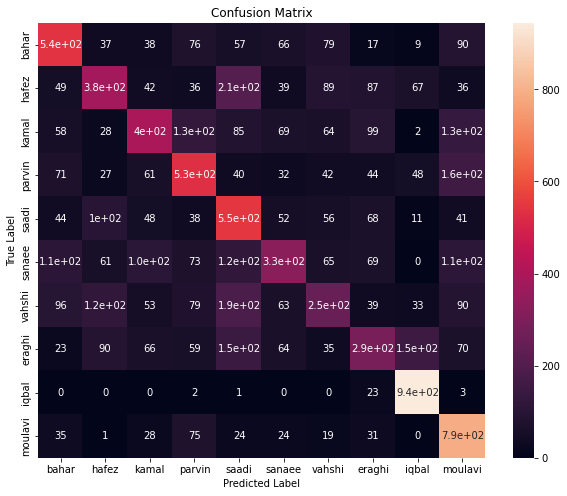

In [ ]:
fig = plot_conf_mat(cm)
plt.show()

# Part C: PrePlexity)

By definition, preplexity is exp(loss). We can see that the preplexity after fine-tuning has decreased which means the output data is more probable. Linear-tuning reduces the preplexity a little, but not as much as fine-tuning

In [ ]:
from torch.utils.data import Subset
indices = np.arange(len(data))
np.random.shuffle(indices)
indices = indices[:1000]
tmp_data = Subset(data, indices)

In [ ]:
accuracy, loss, cm = end_to_end_fine_tune_adam.evaluate(tmp_data, BATCH_SIZE, "test")

In [ ]:
print(f"Preplexity after fine-tuninig is: {np.exp(loss)}")

Preplexity after fine-tuninig is: 1.6693293611580147


In [ ]:
language_model_not_trained = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
linear_model_not_trained = nn.Sequential(*[
    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(linear_in_size, len(POETS))
    ])
end_to_end_not_trained = MyModel(language_model_not_trained,
                                    linear_model_not_trained,
                                    "fine-tune",
                                    optimizer="ADAM",
                                    lr=1e-5).to(device)
accuracy, loss, cm = end_to_end_not_trained.evaluate(tmp_data, BATCH_SIZE, "test")
print(f"Preplexity before fine-tuninig is: {np.exp(loss)}")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preplexity before fine-tuninig is: 11.191073496322915


In [1]:
accuracy, loss, cm = end_to_end_linear_tune_adam.evaluate(tmp_data, BATCH_SIZE, "test")
print(f"Preplexity after linear-tuninig is: {np.exp(loss)}")

Preplexity after linear-tuninig is: 4.833030936714452
